# 카메라 스티커앱 : 사진 왕관 씌우기


---

## 1. 데이터 불러오기
### 라이브러리 호출

In [1]:
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt 
import numpy as np 
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 

### 이미지 호출
cv2 이미지 읽기
> * cv2.IMREAD_COLOR : 이미지 파일을 Color로 읽어 들임. 투명한 부분은 무시됨(Default)
> * cv2.IMREAD_GRAYSCALE : 이미지를 Grayscale로 읽어 들임. 실제 이미지 처리시 중간단계로 많이 사용.
> * cv2.IMREAD_UNCHANGED : 이미지파일을 alpha channel까지 포함하여 읽어 들임.
> * cv2.imread('img.png', 0)이라고 호출했다면 이미지를 Grayscale로 읽어 들임.

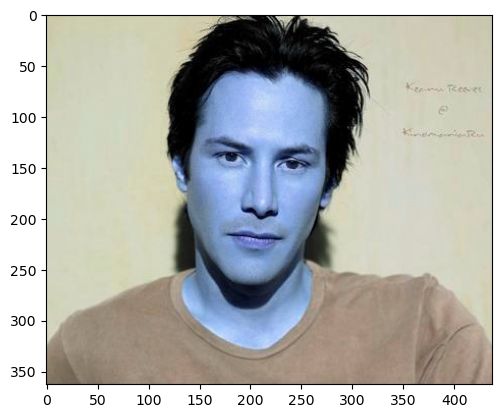

In [5]:
my_image_path = 'image.jpeg' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러오기

img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관.

plt.imshow(img_bgr) # 이미지를 출력하기 위해 출력할 이미지를 올려줌. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

#### opencv는 BGR(파랑, 녹색, 빨강)를 사용하므로 처리를 해야 함

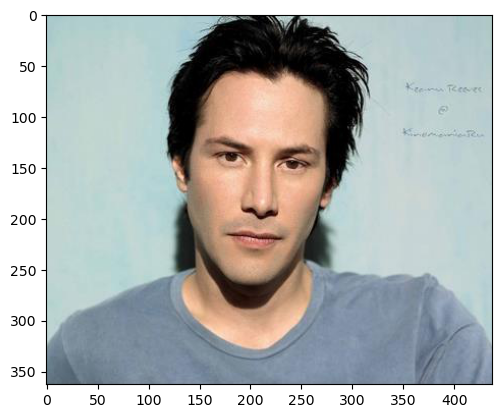

In [6]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

## 2. 얼굴 인식
dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾음.
찾는 방식은 sliding window.
* HOG(Histogram of Oriented Gradients): 이미지에서 색상의 변화량으로 특징을 잡아냄
![HOG](HOG.png)
* SVM(Support Vector Machine)
이미지의 색상만 가지고는 SVM이 큰 힘을 발휘하지 못하지만, 이미지가 HOG를 통해 벡터로 만들어진다면 SVM이 잘 작동함.

In [7]:
# detector를 선언
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

#### detector_hog를 이용해서 얼굴의 bounding box를 추출.
image pyramid : 이미지를 upsampling 방법을 통해 크기를 키우는 것<br>
> [image Pyramid](https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html)

In [8]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(132, 98) (287, 253)]]


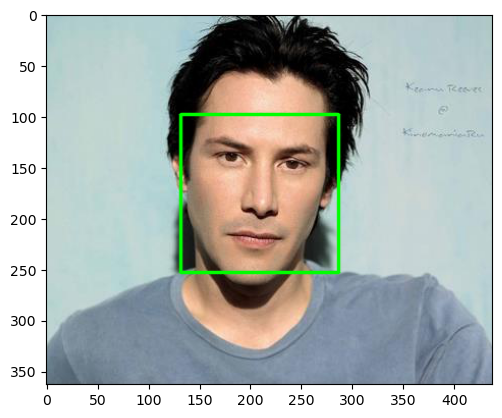

In [9]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있음
print(dlib_rects)   

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3. 얼굴 랜드마크를 추적 : face landmark localization
bounding box 잘라낸 부분에서 이목구비의 위치를 추적

#### Object keypoint estimation 알고리즘
Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 함. keypoint를 찾는 알고리즘은 크게 2가지.
> * top-down : bounding box를 찾고 box 내부의 keypoint를 예측(현재 진행 방향)
> * bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

### Dlib landmark localization : pretrained model 사용
![Dlib landmark localization](dlib.png)
잘라진 얼굴 이미지에서 아래 68개의 이목구비 위치를 찾음.<br><br>

##### 점의 개수는 데이터셋과 논문마다 다름. 예를 들면, AFLW 데이터셋은 21개를 사용하고 ibug 300w 데이터셋은 68개를 사용.

In [10]:
model_path = 'shape_predictor_68_face_landmarks.dat'
    # 저장한 landmark 모델의 주소를 model_path 변수에 저장
landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

In [11]:
list_landmarks = []
    # 랜드마크의 위치를 저장할 list 생성    

# 얼굴 영역 박스 마다 face landmark를 탐색
# face landmark 좌표를 저장.
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list 
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

68


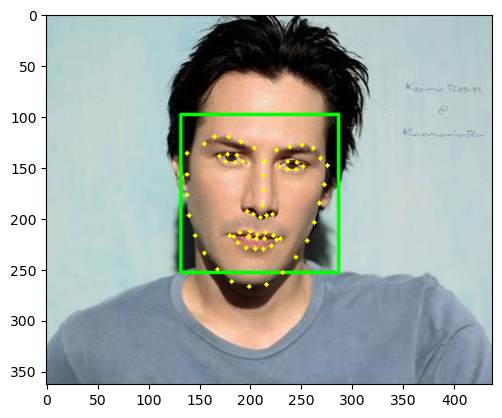

In [13]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    # RGB 이미지로 전환
plt.imshow(img_show_rgb)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

## 4. 스티커 적용
랜드마크를 기준으로 '눈썹 위 얼굴 중앙' 에 스티커를 씌울 것
* 스티커 위치
> $ x = x_{nose} $<br>
> $ y = y_{nose} - {{height}\over{2}} $
* 스티커 크기
$ width = height = width_{bbox} $

In [14]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
# → rectangles[[(345, 98) (531, 284)]]
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))
# → [[(368, 153), (368, 174), (371, 195), (376, 215), (382, 235), (391, 252), (404, 266), (420, 277), (441, 279), (461, 276), (480, 266), (495, 252), (508, 235), (516, 216), (520, 195), (523, 173), (524, 151), (377, 131), (386, 119), (399, 116), (413, 118), (425, 124), (454, 121), (466, 114), (481, 112), (494, 114), (503, 127), (439, 143), (438, 156), (438, 169), (437, 182), (423, 197), (431, 199), (438, 200), (446, 199), (454, 197), (391, 147), (399, 142), (409, 143), (416, 149), (408, 150), (399, 150), (464, 147), (472, 141), (482, 141), (489, 145), (482, 149), (473, 149), (411, 227), (421, 222), (432, 218), (439, 220), (446, 218), (458, 222), (471, 227), (458, 234), (446, 238), (438, 238), (431, 238), (420, 235), (415, 227), (432, 227), (439, 228), (447, 227), (466, 227), (446, 228), (438, 229), (431, 228)]]

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = landmark[30][1] - dlib_rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 → (437, 182-(186+1//2))
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(212, 187)
(x,y) : (212,109)
(w,h) : (156,156)


(212, 187) = 코의 중심점

In [15]:
sticker_path = os.getenv('HOME')+'/Aiffel_Project/Deep_Learning/Image_Processing/Camera_App/king.png' # 왕관 이미지의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))

print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인

(156, 156, 3)


In [16]:
# x,y,w,h 모두 위에서 반복문 안에서 지정해준 값임
# x는 이미지에서 코 부위의 x값 = 212
# y는 이미지에서 코 부위의 y값 = 109
# w는 얼굴 영역의 가로를 차지하는 픽셀의 수 = 156
# h는 얼굴 영역의 가로를 차지하는 픽셀의 수 = 156
refined_x = x - w // 2 # 212 - (156//2) = 212-78 = 134
refined_y = y - h # 109-156 = -47
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.
# 즉, refined_x, refined_y값에서 왕관 이미지가 시작됨
print ('(x,y) : (%d,%d)'%(refined_x, refined_y)) # 음수 발생 : 이미지 범위를 벗어남
# 우리는 현재 이마 자리에 왕관을 두고 싶은건데, 이마위치 - 왕관 높이를 했더니 이미지의 범위를 초과하여 음수가 나오는 것
# opencv는 ndarray데이터를 사용하는데, ndarray는 음수인덱스에 접근 불가하므로 스티커 이미지를 잘라 줘야 한다.

(x,y) : (134,-47)


#### 음수값 = 이미지의 범위에서 벗어나는 값. 즉 스티커도 그만큼 자른 뒤 삽입해야 한다.

In [17]:
# 왕관 이미지가 이미지 밖에서 시작하지 않도록 조정이 필요함
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# 현재 상황에서는 -y 크기만큼 스티커를 crop 하고, top 의 x좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정하면 아래와 같은 형식으로 나옵니다.
# 음수값 만큼 왕관 이미지(혹은 추후 적용할 스티커 이미지)를 자른다.
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
# 왕관 이미지를 씌우기 위해 왕관 이미지가 시작할 y좌표 값 조정

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] # refined_y가 -98이므로, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
    refined_y = 0

    
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (134,0)


In [18]:
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지.
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# 왕관 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용.
# 왕관 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다.
# 현재 왕관 이미지에서는 왕관과 받침대 밑의 ------ 부분이 됨
# 그렇기 때문에 0인 부분(이미지가 없는 부분)은 제외하고 적용
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 왕관 이미지에서 왕관 이미지가 없는 부분(왕관과 받침대 밑의 ------ 부분)은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법.
# 아래 코드에서는 img_sticker가 0일 경우(왕관 이미지에서 왕관 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(왕관 이미지)를 적용.
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

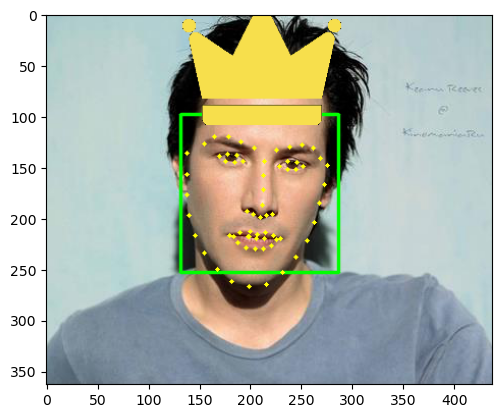

In [19]:
# 왕관 이미지를 적용한 이미지를 보여준다.
# 얼굴 영역(7-3)과 랜드마크(7-4)를 미리 적용해놓은 img_show에 왕관 이미지를 덧붙인 이미지가 나오게 됨.)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#### bounding box와 landmark 표시를 제거

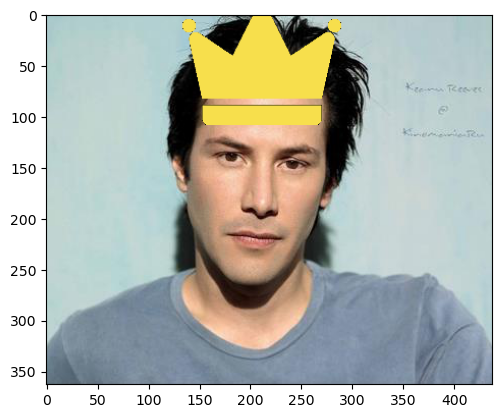

In [20]:
# 위에서 설명했으므로 생략
# 왕관 이미지
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지. 
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()